<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404-0-15-one_sensor_state0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [ ]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x
print(scenario_data[0][:,:].shape)
print(scenario_data[0][:,4].shape)
print(scenario_data[4][:,4].shape)
    # print(fname, x.shape)

(60000, 16)
(60000,)
(60000,)


(60000,)
[-0.0027374  -0.0022796  -0.00162676 ... -0.0025698  -0.00189136
 -0.0011516 ]
0.00035812
-0.0037434


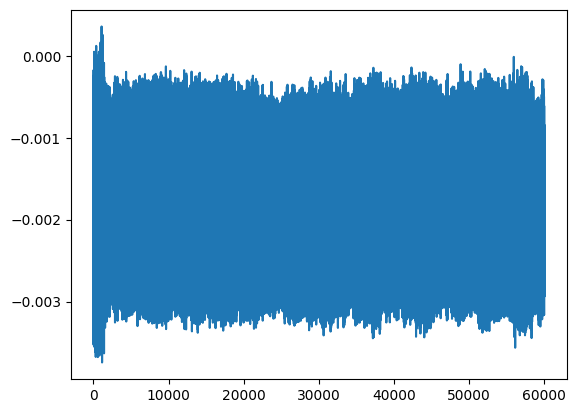

In [ ]:
print(scenario_data[0][:,4].shape)
print(scenario_data[0][:,4])
print(max(scenario_data[0][:,4]))
print(min(scenario_data[0][:,4]))
plt.plot(scenario_data[0][:,4])

(60000,)
-0.0018175
-0.0027156


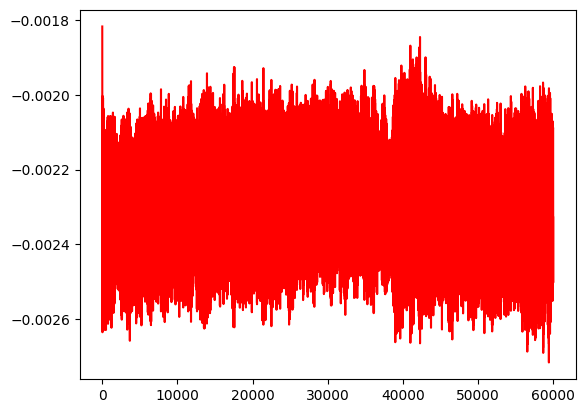

In [ ]:
print(scenario_data[4][:,4].shape)
print(max(scenario_data[4][:,4]))
print(min(scenario_data[4][:,4]))
plt.plot(scenario_data[4][:,4], c='r')

In [ ]:
def create_windows(data, frame_length):
    # Calculate how many full frames can be created
    num_frames = len(data) // frame_length
    # print(num_frames)
    # Trim the data to be a perfect multiple of the frame length
    trimmed_data = data[:num_frames * frame_length]

    # Reshape the data into a 2D array of frames
    frames = trimmed_data.reshape((num_frames, frame_length))
    # return trimmed_data.shape , frames.shape
    return frames

In [ ]:
healthy_frames = create_windows(scenario_data[0][:,4], frame_length = 128)
print("Frames:", healthy_frames.shape)
damaged_frames = create_windows(scenario_data[4][:,4], frame_length = 128)
print("Frames:", damaged_frames.shape)

Frames: (468, 128)
Frames: (468, 128)


In [ ]:
healthy_labels = np.zeros(len(healthy_frames), dtype=int)
print(healthy_labels.shape)

damaged_labels = np.ones(len(damaged_frames), dtype=int)
print(damaged_labels.shape)

(468,)
(468,)


In [ ]:
# 3) Combine, add feature dim, and shuffle the COMBINED set once
X = np.concatenate([healthy_frames, damaged_frames], axis=0)[:, :, None]  # [N, 5, 1]
print(X.shape)
# print(X)
y = np.concatenate([healthy_labels, damaged_labels], axis=0)             # [N]
print(y.shape)

(936, 128, 1)
(936,)


In [ ]:
# One global shuffle to mix classes well
rng = np.random.default_rng(42)
perm = rng.permutation(len(y))

print(perm)
X = X[perm]
y = y[perm]
print(y)

[273 830   2 780 572 660 206 236 918 171 541  25 417  98 365 472 390 694
 131 563 180 875 591 738 556 916 913 218 310 710  82 363 433 354 278 662
 232 185 116 810 626 331 653 315 424  55 152 259 222 166  51 469 382 274
  61  83   7 319 811  36 241 393 527 248 381 281 402 307  38 447 655  96
 127 142 856 879 380  79 594 468 201 610 803 326 804 100 658 426 151 268
 143 498 782 238 708 147 595 909 413 704 671 733 562 150 304 179 193 691
 567 670 367 925  66 128 801 723 914 747 379 361 415 395 873 135 408 627
 761 743 868 352 129  21 753 552 463 305 701 199 336  86 931 758 429 802
 243  88 580 250   6 328 421  11 853 388 245 700 834 120 115  29 513 425
   9 683 910  91 698 154 126 843 260 299 759 674 346 895 840 607 394 760
 570 589 734 285 435 794 224 107 509 676 350 754 787 778 169 276  30 823
 312 203 230 119 368 231 330  35 863 741 756  45 824 479 657 334 746 373
 343 793 785 613 882 744 297 762 839 156  28 926 467 846 601 542 771 253
 493 474 877 239 806 340 101 146  71 399  77 928 35

In [ ]:
# 4) Stratified split: 60% train, 20% val, 20% test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_tmp.shape, y_train.shape, y_tmp.shape)
# print(X_train)
# print(y_train)
# print('tmp:',X_tmp)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)
# print(X_val)
# print(y_val)
print('test:',X_test.shape)
# print(y_test.shape)

(655, 128, 1) (281, 128, 1) (655,) (281,)
(140, 128, 1) (141, 128, 1) (140,) (141,)
test: (141, 128, 1)


In [ ]:
# 5) Torch tensors
X_train = torch.from_numpy(X_train)  # float32
y_train = torch.from_numpy(y_train)  # int64
X_val   = torch.from_numpy(X_val)
y_val   = torch.from_numpy(y_val)
X_test  = torch.from_numpy(X_test)
y_test  = torch.from_numpy(y_test)

In [ ]:
# mu = X_train.mean(dim=(0,1), keepdim=True)
# # print(mu)
# sd = X_train.std(dim=(0,1), keepdim=True).clamp_min(1e-6)
# # print(sd)
# X_train = (X_train - mu) / sd
# # print(X_train)
# X_val   = (X_val   - mu) / sd
# X_test  = (X_test  - mu) / sd

In [ ]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [ ]:
# 6) DataLoaders: shuffle only the training set
batch_size = 100
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]

In [ ]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=2, num_layers=2, d_ff=128, seq_len=5, num_classes=2, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time
        logits = self.head(x)            # [B, C]
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(
    d_model=64,
    nhead=2,
    num_layers=2,
    d_ff=128,
    seq_len=128,
    num_classes=2,
    dropout=0)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cpu


TimeSeriesTransformer(
  (inp): Linear(in_features=1, out_features=64, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# # Optional class weights for CE or focal alpha; compute from training labels
# class_counts = torch.bincount(y_train)
# class_weights = (class_counts.sum() / (class_counts.float().clamp(min=1)))  # inverse freq
# class_weights = class_weights / class_weights.sum() * num_classes           # normalize
# class_weights = class_weights.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def run_epoch(loader, train=True):
    model.train(mode=train)
    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        # print('Logits\n',logits)
        # print('argmax\n',torch.sigmoid(logits.argmax(dim=1)))
        # print('yb\n', yb.shape)
        # print('yb\n', yb)
        loss = loss_fn(logits, yb)

        # print(loss)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            total_loss += loss.item() * yb.size(0)

    return total_loss / total, correct / total

In [ ]:
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
# Small demo loop
for epoch in range(200):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    train_losses.append(tr_loss)
    train_accs  .append(tr_acc)
    val_losses  .append(va_loss)
    val_accs    .append(va_acc)



    print(f"Epoch {epoch+1:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

# Final evaluation
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test  | loss {test_loss:.4f} acc {test_acc:.3f}")

Epoch 01 | train loss 0.7459 acc 0.476 | val loss 0.7165 acc 0.500
Epoch 02 | train loss 0.7037 acc 0.487 | val loss 0.6971 acc 0.500
Epoch 03 | train loss 0.6953 acc 0.498 | val loss 0.6979 acc 0.500
Epoch 04 | train loss 0.6984 acc 0.475 | val loss 0.6939 acc 0.500
Epoch 05 | train loss 0.6966 acc 0.498 | val loss 0.6942 acc 0.500
Epoch 06 | train loss 0.7045 acc 0.460 | val loss 0.6931 acc 0.500
Epoch 07 | train loss 0.6974 acc 0.501 | val loss 0.6940 acc 0.500
Epoch 08 | train loss 0.6938 acc 0.508 | val loss 0.6953 acc 0.500
Epoch 09 | train loss 0.6998 acc 0.470 | val loss 0.6949 acc 0.500
Epoch 10 | train loss 0.6962 acc 0.490 | val loss 0.6940 acc 0.500
Epoch 11 | train loss 0.6943 acc 0.510 | val loss 0.6946 acc 0.500
Epoch 12 | train loss 0.6959 acc 0.478 | val loss 0.6939 acc 0.500
Epoch 13 | train loss 0.6924 acc 0.525 | val loss 0.6956 acc 0.500
Epoch 14 | train loss 0.6948 acc 0.501 | val loss 0.6934 acc 0.500
Epoch 15 | train loss 0.6953 acc 0.499 | val loss 0.6933 acc 0

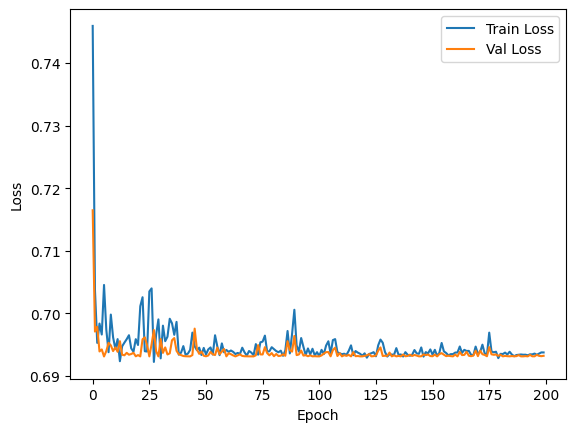

In [ ]:
epoch = np.arange(0, 200, 1) # Create epoch with length 20
import matplotlib.pyplot as plt

plt.plot(epoch, train_losses , label="Train Loss")
plt.plot(epoch, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

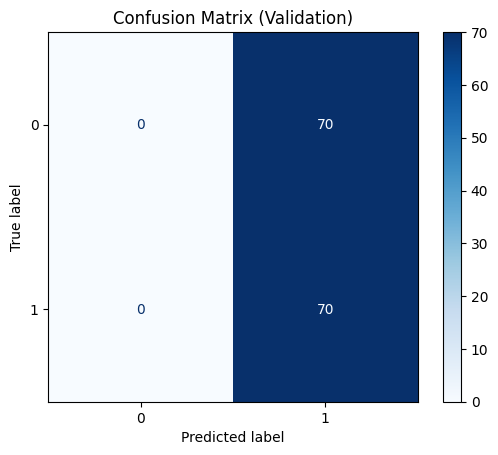

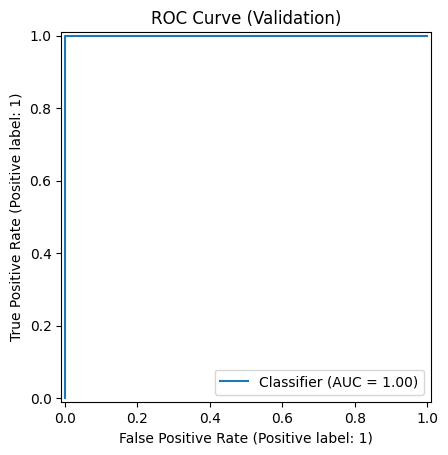

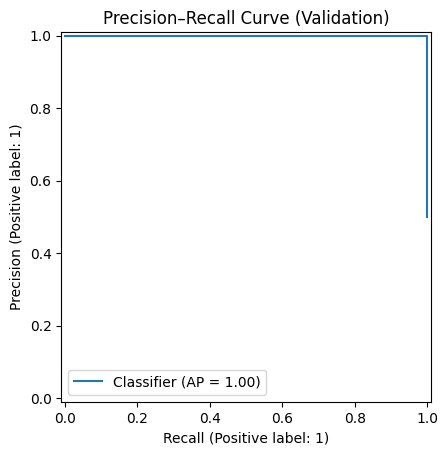

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

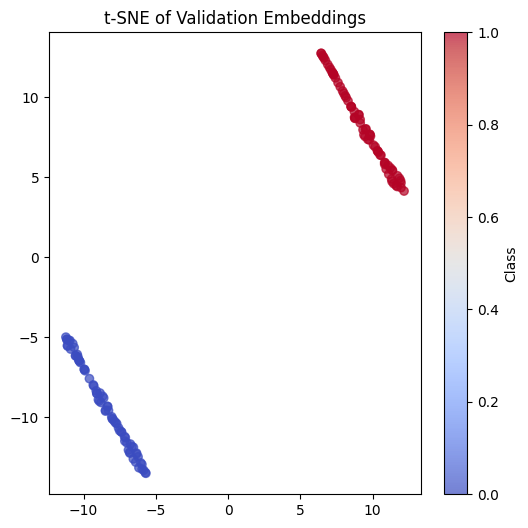

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()

In [ ]:
# healthy_frames = create_windows(scenario_data[0][:,4], frame_length = 128)
# healthy_labels = np.zeros(len(scenario_data[0][:,4]) //  128)
# print("Frames:\n", healthy_frames)
# # print("Labels:", healthy_labels)

# combined_data = np.hstack((healthy_frames, healthy_labels.reshape(-1, 1)))
# np.random.shuffle(combined_data)
# shuffled_time_series = combined_data
# print("Shuffeled_Frames:\n", combined_data)


In [ ]:
# def split(dataset, ratios=(0.7, 0.1, 0.2)):
#     # idx = np.arange(dataset.shape[0])
#     n_train = int(ratios[0] * dataset.shape[0])
#     print(n_train)
#     n_val   = int(ratios[1] * dataset.shape[0])
#     print(n_val)
#     train_ids = dataset[:n_train]
#     val_ids   = dataset[n_train:n_train+n_val]
#     test_ids  = dataset[n_train+n_val:]
#     return train_ids, val_ids, test_ids

In [ ]:
# train_combined, val_combined, test_combined = split(combined_data)

# train_ids = train_combined[:, :-1]  # All columns except the last one
# train_ids_labels = train_combined[:, -1] # The last column
# print(train_ids_labels.shape)
# val_ids = val_combined[:, :-1]
# val_ids_labels = val_combined[:, -1]

# test_ids = test_combined[:, :-1]
# test_ids_labels = test_combined[:, -1]

# # train_ids, val_ids, test_ids = split(shuffled_time_series)
# print(train_ids,train_ids_labels,val_ids,val_ids_labels, test_ids, test_ids_labels)

In [ ]:
# print(train_ids.max())
# print(train_ids.min())
# train_ids = (train_ids - train_ids.min())/(train_ids.max()-train_ids.min())
# print(train_ids)

In [ ]:


# healthy_data_stack = np.hstack((healthy_frames, healthy_labels.reshape(-1, 1)))
# np.random.shuffle(healthy_data_stack)
# shuffled_healthy_frames = healthy_data_stack

# train_H, val_H, test_H = split(shuffled_healthy_frames)
# print("Training data shape:", train_H.shape)
# # 4) Standardize using train only
# m = train_H[:,:-1].mean()
# s = train_H[:,:-1].std()
# train_H[:,:-1] = (train_H[:,:-1] - m) / s
# val_H[:,:-1]   = (val_H[:,:-1]   - m) / s
# test_H[:,:-1]  = (test_H[:,:-1]  - m) / s

In [ ]:

# damaged_data_stack = np.hstack((damaged_frames, damaged_labels.reshape(-1,1)))
# np.random.shuffle(damaged_data_stack)
# shuffled_damaged_frames = damaged_data_stack

# train_D, val_D, test_D = split(shuffled_damaged_frames)

# print("Training data shape:", train_D[:,-1])
# m = train_D[:,:-1].mean()
# s = train_D[:,:-1].std ()
# train_D[:,:-1] = (train_D[:,:-1] - m) / s
# val_D[:,:-1]   = (val_D[:,:-1]   - m) / s
# test_D[:,:-1]  = (test_D[:,:-1]  - m) / s

In [ ]:
# H = [[3,2,3],[2,5,2]]
# D = [[0,0,1],[2,2,0]]
# train_combined0 = np.concatenate((H, D), axis=0)
# print(train_combined0)
# print(train_combined0[:,:-1].mean())

In [ ]:
# from torch.utils.data import random_split
# from torch.utils.data import TensorDataset

# train_combined = np.concatenate((train_H, train_D), axis=0)
# print(train_combined[:,-1])
# print(train_combined.shape)
# val_combined   = np.concatenate((val_H, val_D), axis=0)
# test_combined  = np.concatenate((test_H, test_D), axis=0)

# indices0 = np.arange(train_combined.shape[0])
# indices1 = np.arange(val_combined.shape[0])
# indices2 = np.arange(test_combined.shape[0])
# np.random.shuffle(indices0)
# np.random.shuffle(indices1)
# np.random.shuffle(indices2)

# X_train = train_combined[indices0][:, :-1]
# print(type(X_train))
# Y_train = train_combined[indices0][:, -1]
# print(Y_train)

# X_val = val_combined[indices1][:, :-1]
# Y_val = val_combined[indices1][:, -1]

# X_test = test_combined[indices2][:, :-1]
# Y_test = test_combined[indices2][:, -1]

# dataset_train = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long())
# dataset_val   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).long())
# dataset_test  = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).long())

# # dataset_train = TensorDataset(torch.from_numpy(train_combined[:, :-1]).float(), torch.from_numpy(train_combined[:, -1]).long())
# # dataset_val   = TensorDataset(torch.from_numpy(val_combined[:, :-1]).float(), torch.from_numpy(val_combined[:, -1]).long())
# # dataset_test  = TensorDataset(torch.from_numpy(test_combined[:, :-1]).float(), torch.from_numpy(test_combined[:, -1]).long())

# print("Training data shape:", X_train.shape)
# # print("Training labels shape:", Y_train.shape)
# print('Y_train',Y_train)

# print("val data shape:", X_val.shape)
# print("val labels shape:", Y_val.shape)

# print("Test data shape:", X_test.shape)
# print("Test labels shape:", Y_test.shape)

# batch_size = 32

# train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
# val_loader   = DataLoader(dataset_val ,  batch_size = batch_size, shuffle = False)
# test_loader  = DataLoader(dataset_test,  batch_size = batch_size, shuffle = False)

# print(train_loader)

# xb, yb = next(iter(train_loader))
# xb = xb.unsqueeze(-1)
# yb = yb.unsqueeze(-1)
# print("train batch X:", xb.shape)  # (32, 1024, 15)
# print("train batch y:", yb.shape)

In [ ]:
# import torch
# import torch.nn as nn

# class TimeSeriesTransformer(nn.Module):
#     def __init__(self,n_channels=1,d_model=128,n_heads=4,num_layers=3,d_ff=256,dropout=0.1,seq_len=512,num_classes=2):
#         super().__init__()
#         self.input_proj = nn.Linear(in_features = n_channels, out_features = d_model)
#         self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, d_model))
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,nhead=n_heads,dim_feedforward=d_ff,dropout=dropout,batch_first=True)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.classifier = nn.Sequential(nn.LayerNorm(d_model),
#                                         nn.Linear(d_model, d_model//2),
#                                         nn.GELU(),
#                                         nn.Dropout(dropout),
#                                        nn.Linear(d_model//2, num_classes))
#     def forward(self, x):
#         x = self.input_proj(x)                        # → (batch, seq_len, d_model)
#         x = x + self.pos_emb[:, :x.size(1), :]        # → (batch, seq_len, d_model)
#         x = self.transformer(x)                       # → (batch, seq_len, d_model)
#         x = x.mean(dim=1)                             # → (batch, d_model)
#         return self.classifier(x)                     # → (batch, num_classes)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# model  = TimeSeriesTransformer(
#     n_channels=1,
#     d_model=128,
#     n_heads=4,
#     num_layers=3,
#     d_ff=256,
#     dropout=0.1,
#     seq_len=512,
#     num_classes=2
# ).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
# print(model)

In [ ]:
# train_losses = []
# val_losses   = []
# train_accs   = []
# val_accs     = []

In [ ]:
# from sklearn.metrics import accuracy_score
# # Training loop
# from datetime import datetime
# def train_epoch(loader):
#     model.train()
#     running_loss = 0.0
#     preds, targets = [], []
#     for xb, yb in loader:
#         xb, yb = xb.unsqueeze(-1).to(device), yb.to(device)
#         optimizer.zero_grad()
#         logits = model(xb)
#         loss = criterion(logits, yb)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * xb.size(0)
#         preds.extend(logits.argmax(dim=1).cpu().tolist())
#         targets.extend(yb.cpu().tolist())

#     avg_loss = running_loss / len(loader.dataset)
#     acc = accuracy_score(targets, preds)
#     return avg_loss, acc

# def eval_epoch(loader):
#     model.eval()
#     running_loss = 0.0
#     preds, targets = [], []
#     with torch.no_grad():
#         for xb, yb in loader:
#             xb, yb = xb.unsqueeze(-1).to(device), yb.to(device)
#             logits = model(xb)
#             loss = criterion(logits, yb)

#             running_loss += loss.item() * xb.size(0)
#             preds.extend(logits.argmax(dim=1).cpu().tolist())
#             targets.extend(yb.cpu().tolist())

#     avg_loss = running_loss / len(loader.dataset)
#     acc = accuracy_score(targets, preds)
#     return avg_loss, acc


In [ ]:
# num_epochs = 50
# best_val_acc = 0.0

# for epoch in range(1, num_epochs+1):
#     train_loss, train_acc = train_epoch(train_loader)
#     val_loss, val_acc     = eval_epoch(val_loader)
#     # scheduler.step()

#     train_losses.append(train_loss)
#     train_accs  .append(train_acc)
#     val_losses  .append(val_loss)
#     val_accs    .append(val_acc)

#     print(f"Epoch {epoch:02d} │ "
#           f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} ││ "
#           f"Val:   loss={val_loss:.4f}, acc={val_acc:.3f}")

#     # save best model
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), "best_asce_transformer.pt")
#         print("  ↳ new best, model saved.")